In [1]:
import sys
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt

import torch
import anndata as an
import scanpy as sc
import os
import gc
from importlib import reload

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer

# classifer tools
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score

# local imports
sys.path.insert(0, '../../scripts/')
import geneformer_utils as gtu

sns.set_style('white')
torch.cuda.empty_cache()

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""Load the model"""
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
model_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/240711_geneformer_cellClassifier_prepared_hsc/ksplit1/"
model = gtu.load_model(model_path)
print('loaded!')

Some weights of BertForMaskedLM were not initialized from the model checkpoint at /scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/240711_geneformer_cellClassifier_prepared_hsc/ksplit1/ and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loaded!


In [3]:
fpath = "/scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/hsc.dataset"
sample_size = 100000
df = gtu.load_data_as_dataframe(fpath, 
                                num_cells=sample_size, 
                                shuffle=True)
print(f"{df.shape=}")
data = Dataset.from_pandas(df)
data

df.shape=(100000, 8)


Dataset({
    features: ['input_ids', 'cell_type', 'dataset', 'length', 'ignore', 'standardized_cell_type', 'broad_type', '__index_level_0__'],
    num_rows: 100000
})

100%|██████████| 10000/10000 [45:43<00:00,  3.65it/s]


embs.shape=(100000, 512)


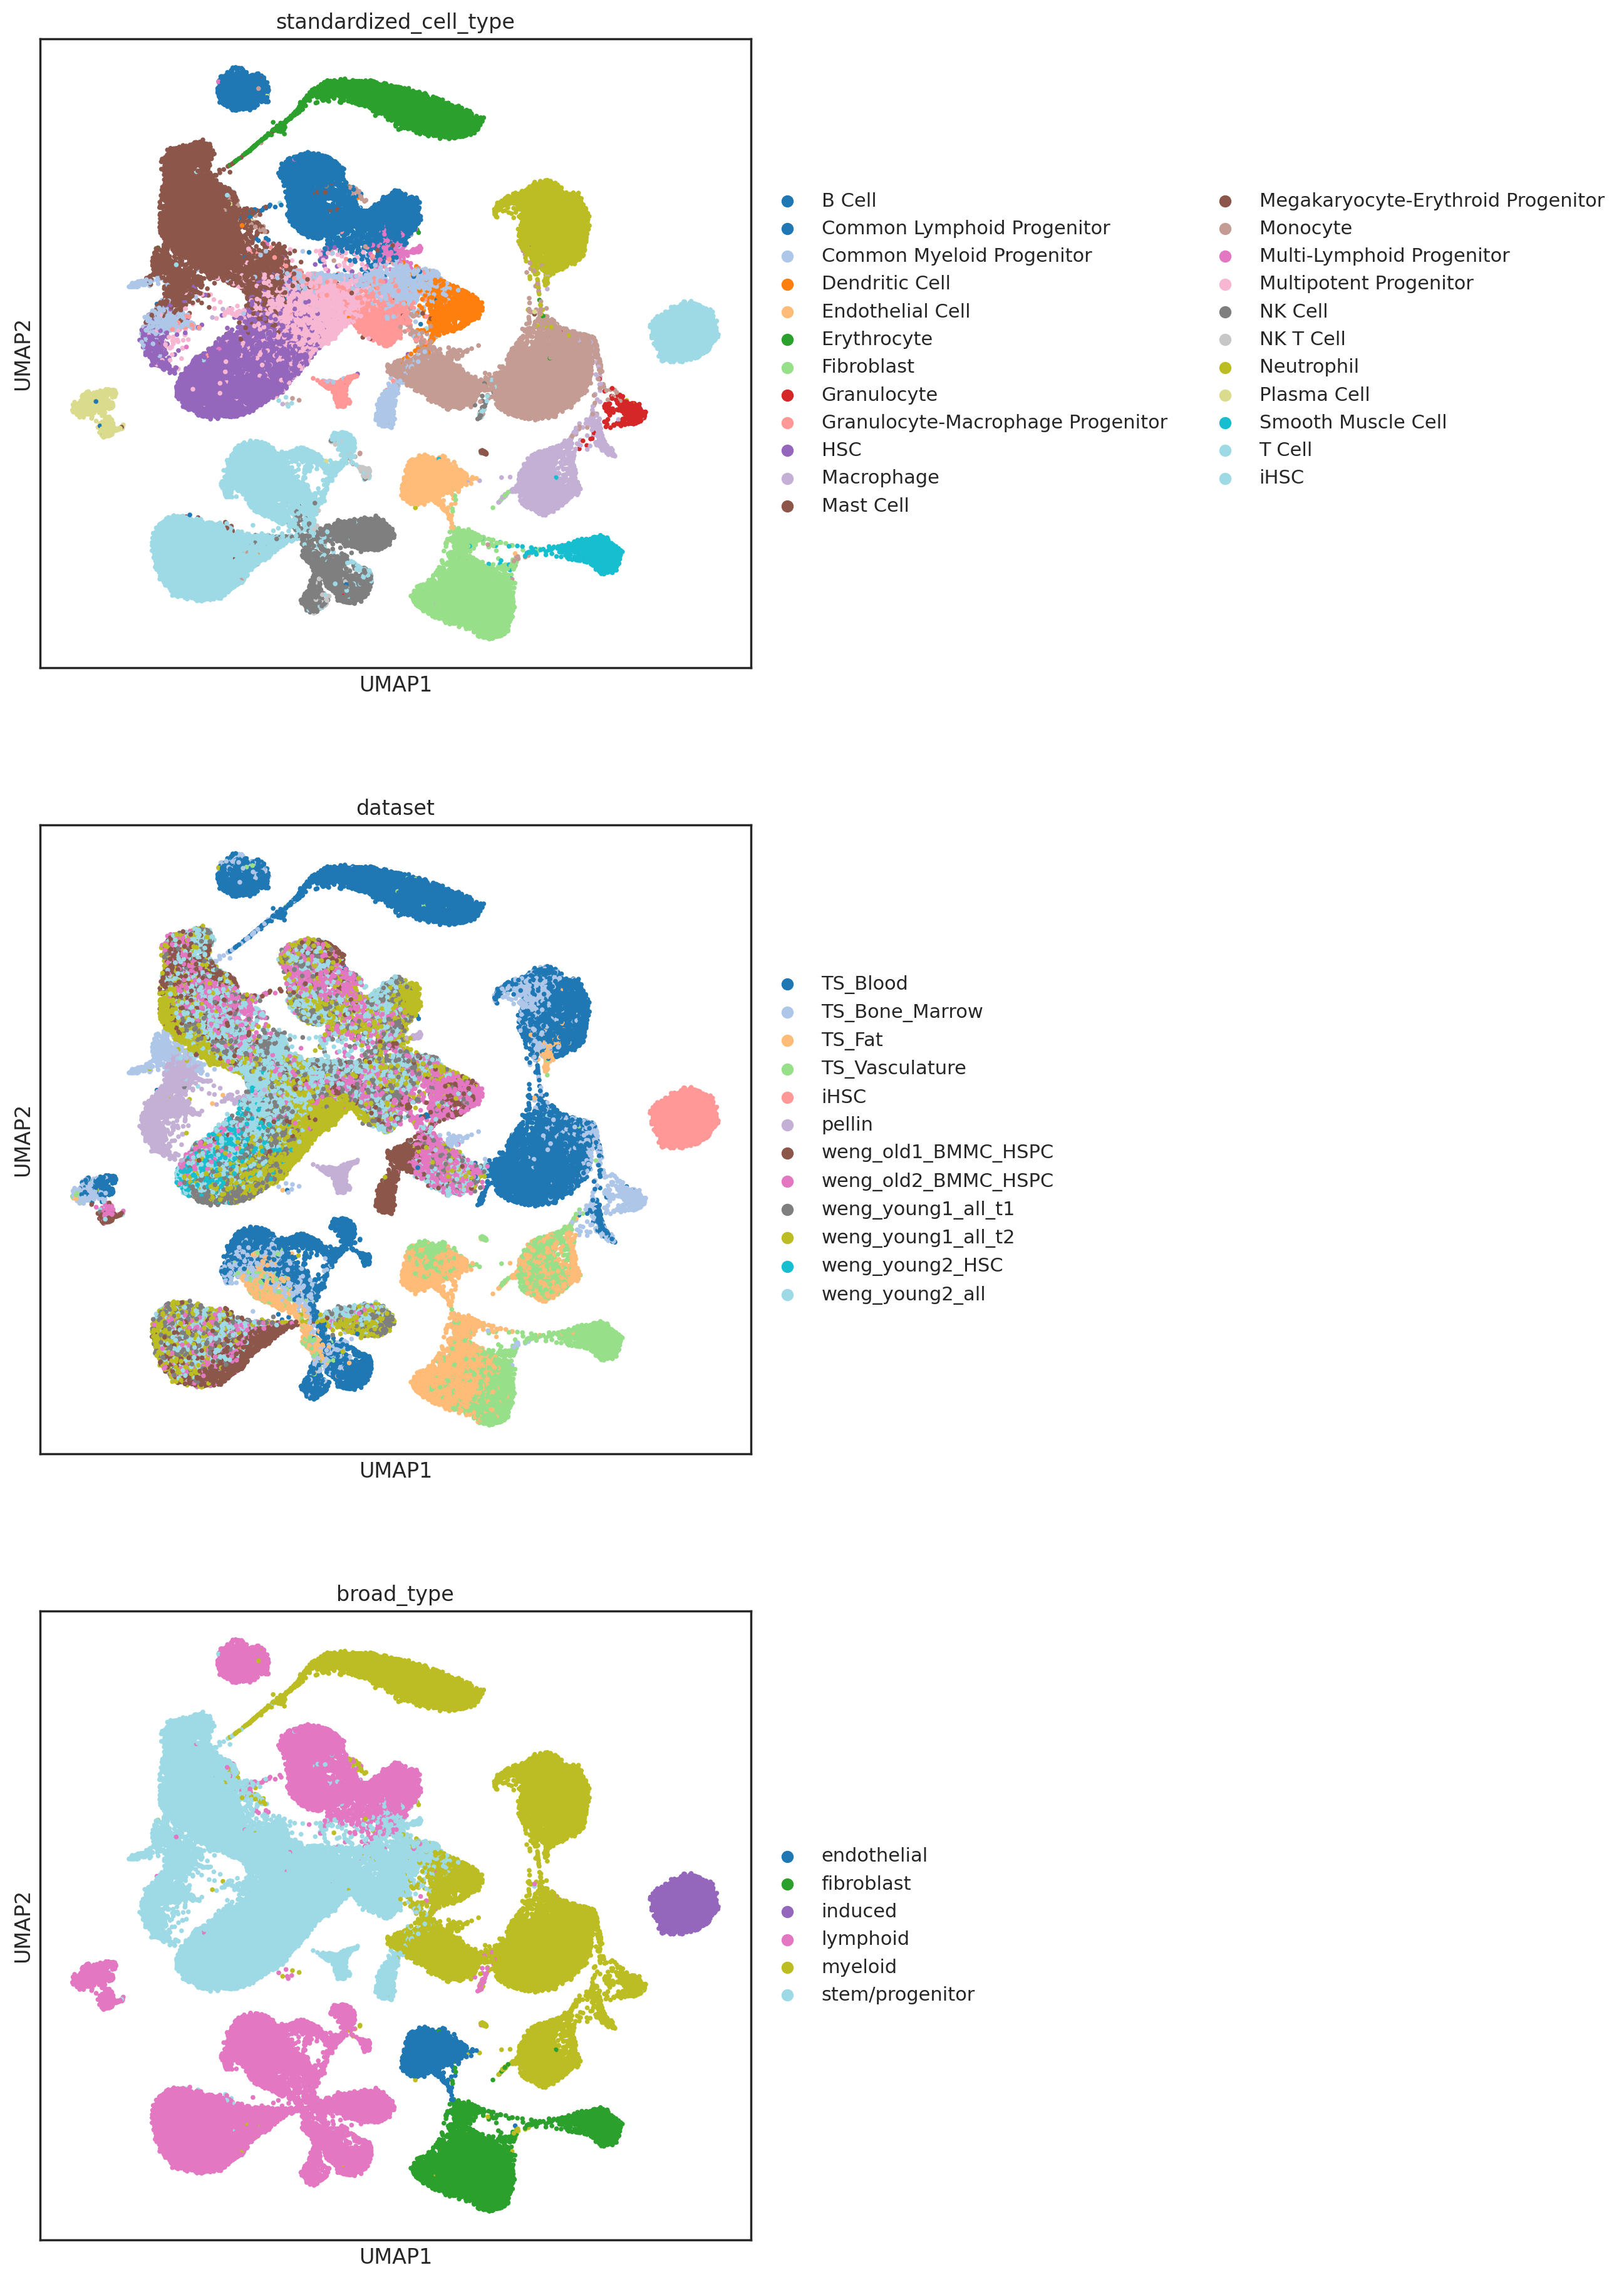

AnnData object with n_obs × n_vars = 100000 × 512
    obs: 'input_ids', 'cell_type', 'dataset', 'length', 'ignore', 'standardized_cell_type', 'broad_type', '__index_level_0__'
    uns: 'pca', 'neighbors', 'umap', 'standardized_cell_type_colors', 'dataset_colors', 'broad_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
reload(gtu)
torch.cuda.empty_cache()
embs = gtu.extract_embedding_in_mem(model, data, layer_to_quant=-1)
print(f"{embs.shape=}")

# translate into an anndata object and plot
finetuned = gtu.embedding_to_adata(embs)
finetuned.obs = df.copy()

sc.tl.pca(finetuned)
sc.pp.neighbors(finetuned)
sc.tl.umap(finetuned)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7

sc.pl.umap(
    finetuned,
    color=["standardized_cell_type", "dataset", "broad_type"],
    palette='tab20',
    ncols=1,
    size=30,
)

finetuned

In [5]:
# break

# how do these compare to the pretrainned embeddings?

In [6]:
"""Load the model"""
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model = gtu.load_model(model_path)
print('loaded!')

loaded!


100%|██████████| 10000/10000 [45:30<00:00,  3.66it/s]


embs.shape=(100000, 512)


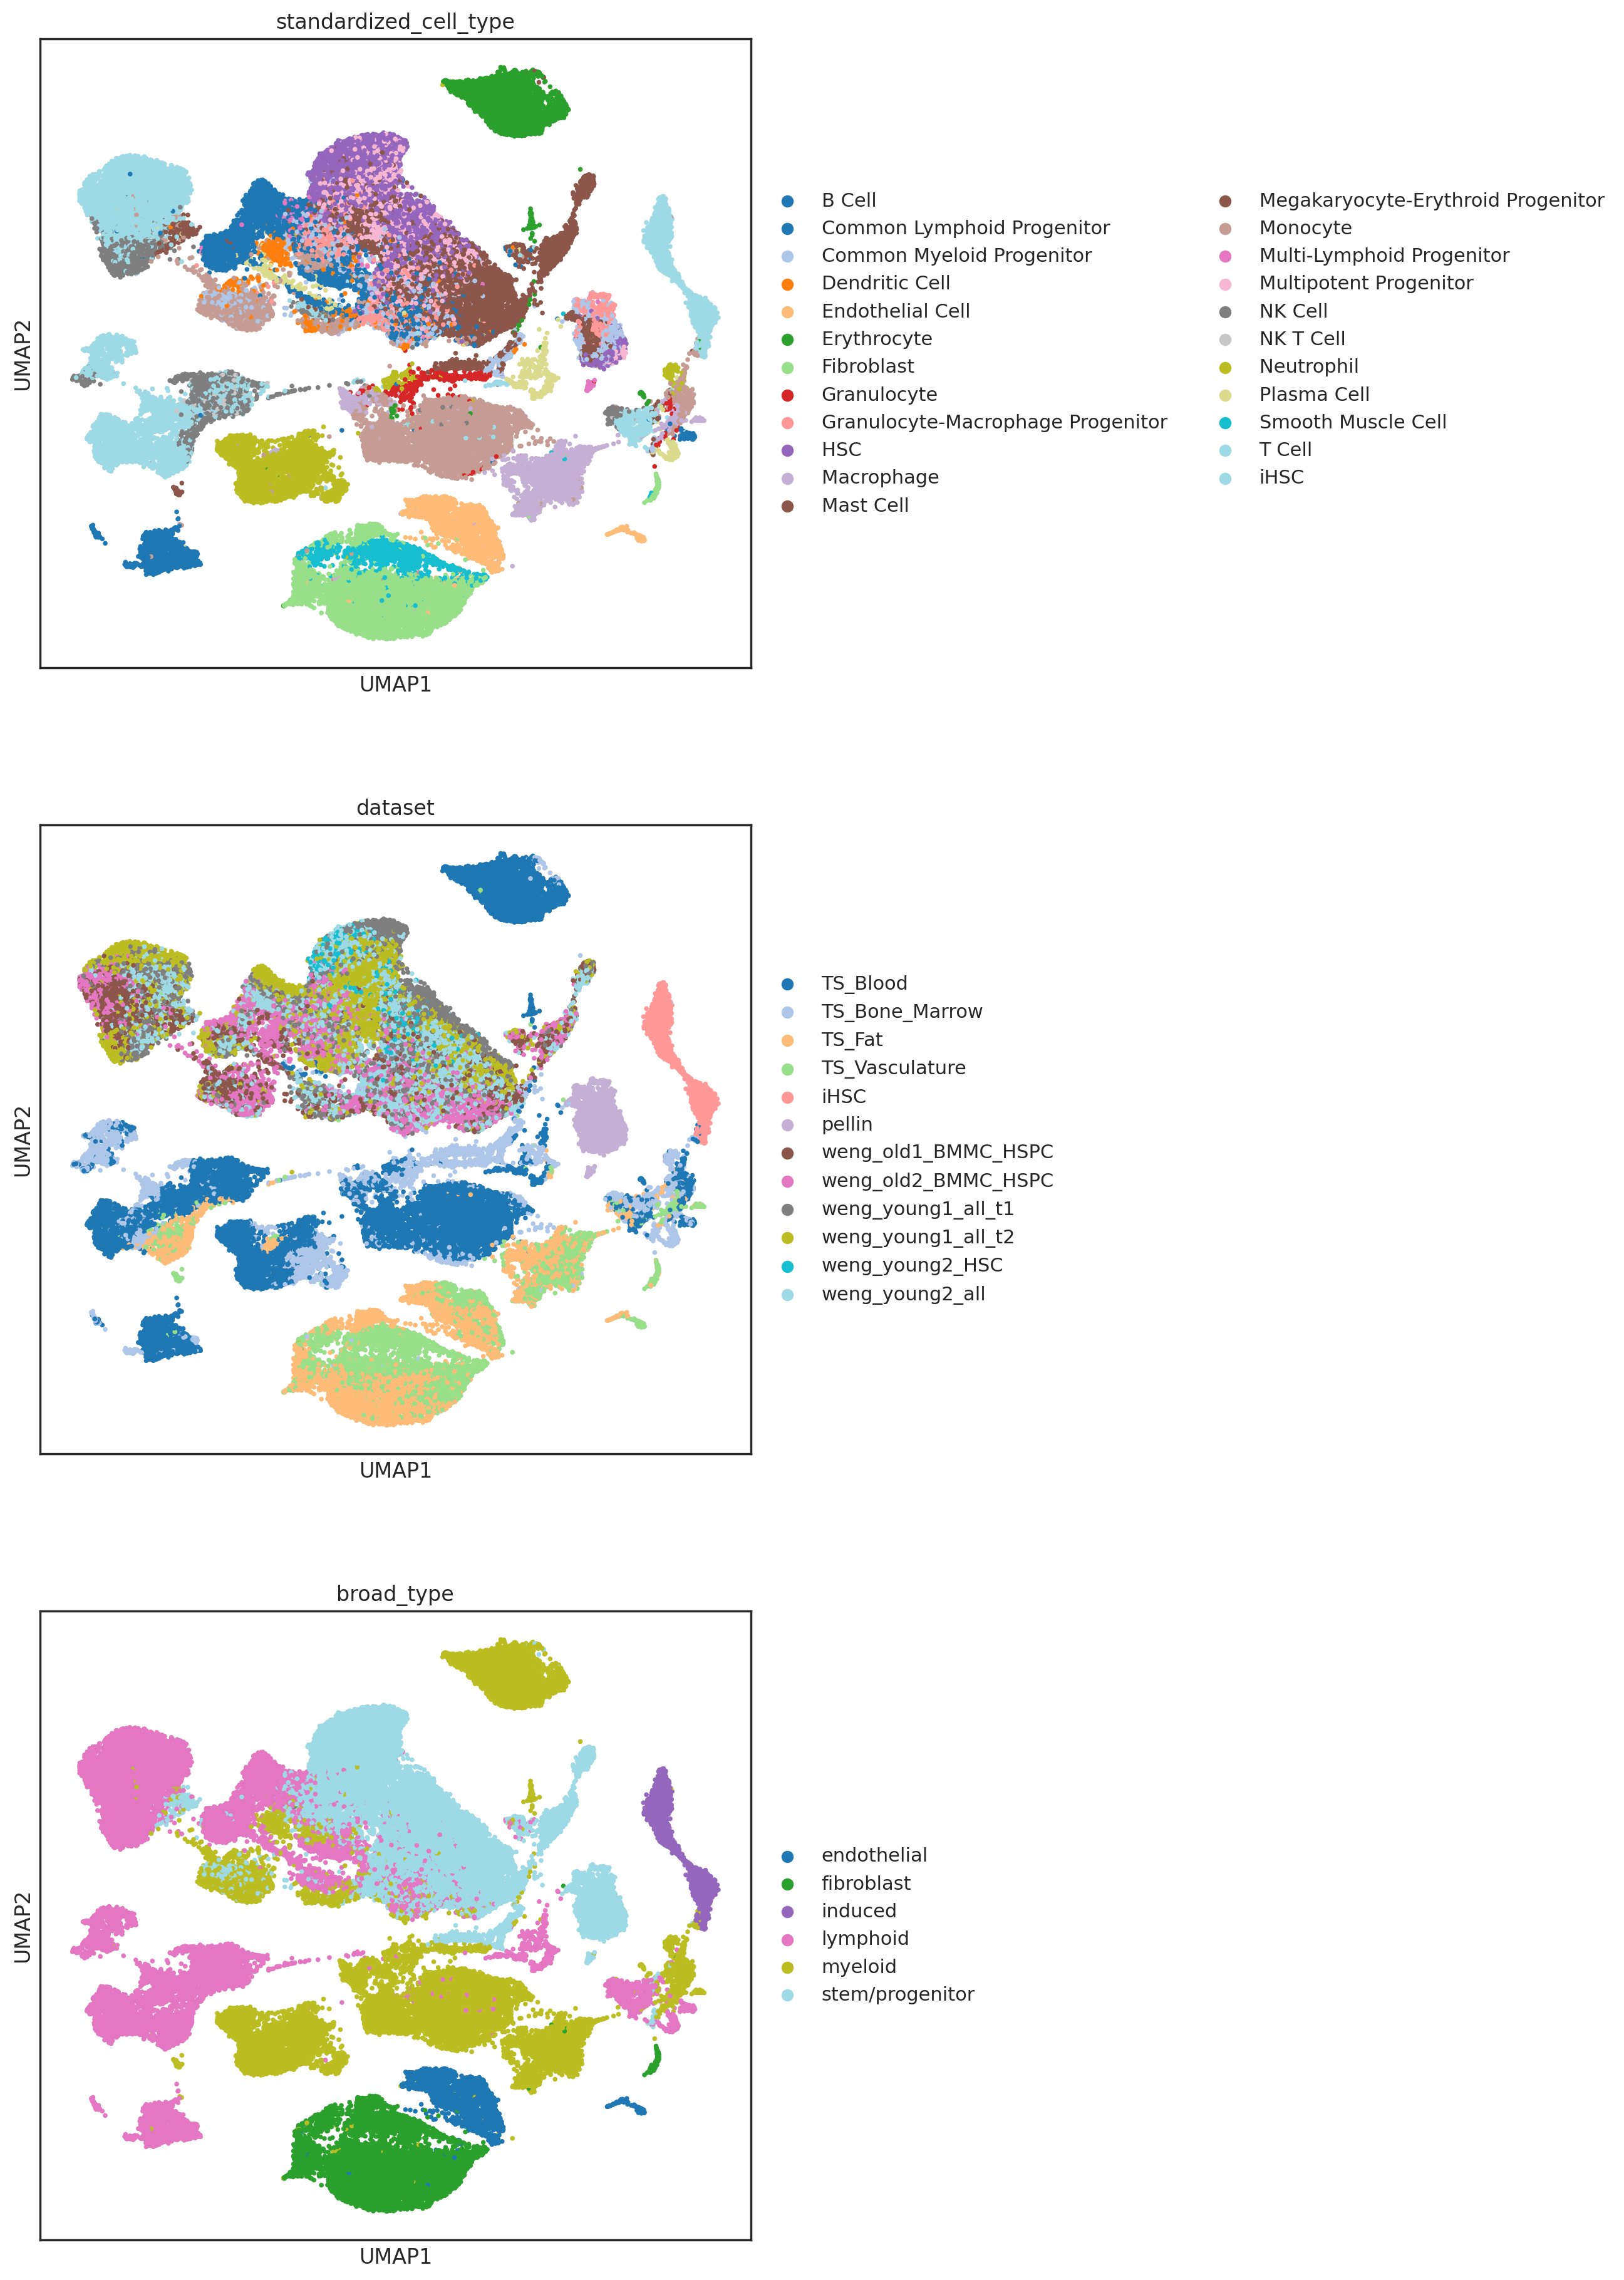

AnnData object with n_obs × n_vars = 100000 × 512
    obs: 'input_ids', 'cell_type', 'dataset', 'length', 'ignore', 'standardized_cell_type', 'broad_type', '__index_level_0__'
    uns: 'pca', 'neighbors', 'umap', 'standardized_cell_type_colors', 'dataset_colors', 'broad_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [7]:
reload(gtu)
torch.cuda.empty_cache()
embs = gtu.extract_embedding_in_mem(model, data, layer_to_quant=-1)
print(f"{embs.shape=}")

# translate into an anndata object and plot
pretrained = gtu.embedding_to_adata(embs)
pretrained.obs = df.copy()

sc.tl.pca(pretrained)
sc.pp.neighbors(pretrained)
sc.tl.umap(pretrained)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7

sc.pl.umap(
    pretrained,
    color=["standardized_cell_type", "dataset", "broad_type"],
    palette='tab20',
    ncols=1,
    size=30,
)

pretrained

# Compare and Contrast

In [8]:
def compute_silhouette_score(adata, cluster_key):
    """Computes the average silhouette score for an AnnData object
       using the .X data.

    Args:
        adata: AnnData object containing the data and cluster assignments.
        cluster_key: Column in adata.obs containing cluster assignments.

    Returns:
        float: The average silhouette score.
    """

    X_data = adata.X
    labels = adata.obs[cluster_key].values

    # Compute silhouette score
    silhouette_avg = silhouette_score(X_data, labels, metric='euclidean')  # Adjust metric if needed

    print(f"Average silhouette score for '{cluster_key}': {silhouette_avg:.3f}")
    return silhouette_avg
    
    
compute_silhouette_score(pretrained, 'standardized_cell_type')
compute_silhouette_score(finetuned, 'standardized_cell_type')

Average silhouette score for 'standardized_cell_type': 0.072
Average silhouette score for 'standardized_cell_type': 0.540


0.54000175

In [9]:
# for data set
compute_silhouette_score(pretrained, 'dataset')
compute_silhouette_score(finetuned, 'dataset')

Average silhouette score for 'dataset': -0.019
Average silhouette score for 'dataset': -0.009


-0.009108035

In [10]:
compute_silhouette_score(pretrained, 'broad_type')
compute_silhouette_score(finetuned, 'broad_type')

Average silhouette score for 'broad_type': 0.117
Average silhouette score for 'broad_type': 0.225


0.22469807